# Imports

In [4]:
!cp -r ../input/library/* /kaggle/working/

In [7]:
!pip install -r requirements.txt

  Using cached lightfm-1.17.tar.gz (316 kB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 31.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.5/23.5 MB 51.6 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 466.9/466.9 kB 37.2 MB/s eta 0:00:00
  Created wheel for lightfm: filename=lightfm-1.17-cp310-cp310-linux_x86_64.whl size=447716 sha256=62693796082e22e62ef3746f4cec03430f31ff2d4cff8b4cea1317dac381effb
  Stored in directory: /root/.cache/pip/wheels/4f/9b/7e/0b256f2168511d8fa4dae4fae0200fdbd729eb424a912ad636
  Created wheel for jupyter-contrib-nbextensions: filename=jupyter_contrib_nbextensions-0.7.0-py2.py3-none-any.whl size=23428781 sha256=0e12b707fc8519ef6ac37bd6946f5877f3fd1840a63a88f7cc37ab60ce217f42
  Stored in directory: /root/.cache/pip/wheels/ea/cc/7d/99ef154f984726b1201c0f72cfe9c9d7c5132c1a2ae4

In [8]:
!pip install lightfm tqdm optuna ipykernel matplotlib implicit

  Obtaining dependency information for implicit from https://files.pythonhosted.org/packages/cd/cc/deac70cae8cc32c9885d0cd73bc66e1b3cbea36ae7080b8c83995eaf5322/implicit-0.7.2-cp310-cp310-manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 47.5 MB/s eta 0:00:0000:0100:01


In [9]:
!python run_compile_all_cython.py

run_compile_all_cython: Found 10 Cython files in 4 folders...
run_compile_all_cython: All files will be compiled using your current python environment: '/opt/conda/bin/python'
Compiling [1/10]: MatrixFactorization_Cython_Epoch.pyx... 
In file included from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1940,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from MatrixFactorization_Cython_Epoch.c:1109:
/opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wcpp-Wcpp]8;;]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
M

In [10]:
import time
import optuna
import numpy as np
import pandas as pd
import scipy.sparse as sps
from scipy.sparse import vstack, csr_matrix
from scipy.stats import loguniform
from lightfm import LightFM
from lightfm.evaluation import auc_score, precision_at_k
import matplotlib.pyplot as plt
from multiprocessing import cpu_count

In [11]:
from Recommenders.BaseRecommender import BaseRecommender
from Recommenders.BaseMatrixFactorizationRecommender import BaseMatrixFactorizationRecommender
from Recommenders.NonPersonalizedRecommender import TopPop

#---- CF
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender

#---- Matrix Factorization
from Recommenders.MatrixFactorization.NMFRecommender import NMFRecommender

#---- CF w/ ML
from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender, MultiThreadSLIM_SLIMElasticNetRecommender
from implicit.als import AlternatingLeastSquares

#---- Others
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Evaluation.Evaluator import EvaluatorHoldout
from Recommenders.Recommender_utils import check_matrix

In [12]:
seed = 69
np.random.seed(seed)

# Data Import and Preprocessing

In [13]:
# Import training data
URM_path = "../input/data-book/data_train.csv"
URM_all_dataframe = pd.read_csv(filepath_or_buffer=URM_path,
                                header=0,
                                dtype={0:int, 1:int, 2:int},
                                engine='python')

URM_all_dataframe.columns = ["user_id", "item_id", "interaction"]

In [14]:
# Import target users
target_path = "../input/data-book/data_target_users_test.csv"
target_dataframe= pd.read_csv(filepath_or_buffer=target_path,
                                header=0,
                                dtype={0:int},
                                engine='python')
target_dataframe.columns = ["user_id"]
target_dataframe

,user_id
0,1
1,2
2,3
3,4
4,5
...,...
10877,13020
10878,13021
10879,13022
10880,13023


In [15]:
def preprocess_data(ratings: pd.DataFrame):
    unique_users = ratings.user_id.unique()
    unique_items = ratings.item_id.unique()

    num_users, min_user_id, max_user_id = unique_users.size, unique_users.min(), unique_users.max()
    num_items, min_item_id, max_item_id = unique_items.size, unique_items.min(), unique_items.max()

    print(num_users, min_user_id, max_user_id)
    print(num_items, min_item_id, max_item_id)

    mapping_user_id = pd.DataFrame({"mapped_user_id": np.arange(num_users), "user_id": unique_users})
    mapping_item_id = pd.DataFrame({"mapped_item_id": np.arange(num_items), "item_id": unique_items})

    ratings = pd.merge(left=ratings,
                       right=mapping_user_id,
                       how="inner",
                       on="user_id")

    ratings = pd.merge(left=ratings,
                       right=mapping_item_id,
                       how="inner",
                       on="item_id")

    return ratings

In [16]:
# Call preprocess data function
ratings = preprocess_data(URM_all_dataframe)

12638 1 13024
22222 1 22347


## Conversion to Sparse Matrix

In [17]:
URM = sps.coo_matrix((ratings.interaction.values, (ratings.mapped_user_id.values, ratings.mapped_item_id.values)))

## Data Splits

In [18]:
#urm_train, urm_test= split_train_in_two_percentage_global_sample(URM, train_percentage = 0.80)
urm_train, urm_validation = split_train_in_two_percentage_global_sample(URM, train_percentage = 0.80)

evaluator_validation = EvaluatorHoldout(urm_validation, cutoff_list=[10])
#evaluator_test = EvaluatorHoldout(urm_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 2127 (16.8%) Users that have less than 1 test interactions


# **Custom Models**

In [19]:
class ScoresHybridRecommender(BaseRecommender):
    """ ScoresHybridRecommender
    Hybrid of two prediction scores R = R1*alpha + R2*(1-alpha)

    """

    RECOMMENDER_NAME = "ScoresHybridRecommender"

    def __init__(self, URM_train, recommender_1, recommender_2):
        super(ScoresHybridRecommender, self).__init__(URM_train)

        self.URM_train = sps.csr_matrix(URM_train)
        self.recommender_1 = recommender_1
        self.recommender_2 = recommender_2


    def fit(self, alpha=0.5):
        self.alpha = alpha

    def _compute_item_score(self, user_id_array, items_to_compute):

        # In a simple extension this could be a loop over a list of pretrained recommender objects
        item_weights_1 = self.recommender_1._compute_item_score(user_id_array)
        item_weights_2 = self.recommender_2._compute_item_score(user_id_array)

        item_weights = item_weights_1*self.alpha + item_weights_2*(1-self.alpha)

        return item_weights

In [20]:
class DifferentLossScoresHybridRecommender(BaseRecommender):
    """ ScoresHybridRecommender
    Hybrid of two prediction scores R = R1/norm*alpha + R2/norm*(1-alpha) where R1 and R2 come from
    algorithms trained on different loss functions.

    """

    RECOMMENDER_NAME = "DifferentLossScoresHybridRecommender"


    def __init__(self, URM_train, recommender_1, recommender_2):
        super(DifferentLossScoresHybridRecommender, self).__init__(URM_train)

        self.URM_train = sps.csr_matrix(URM_train)
        self.recommender_1 = recommender_1
        self.recommender_2 = recommender_2
        
        
        
    def fit(self, norm, alpha = 0.5):

        self.alpha = alpha
        self.norm = norm


    def _compute_item_score(self, user_id_array, items_to_compute):
        
        item_weights_1 = self.recommender_1._compute_item_score(user_id_array)
        item_weights_2 = self.recommender_2._compute_item_score(user_id_array)

        norm_item_weights_1 = LA.norm(item_weights_1, self.norm)
        norm_item_weights_2 = LA.norm(item_weights_2, self.norm)
        
        
        if norm_item_weights_1 == 0:
            raise ValueError("Norm {} of item weights for recommender 1 is zero. Avoiding division by zero".format(self.norm))
        
        if norm_item_weights_2 == 0:
            raise ValueError("Norm {} of item weights for recommender 2 is zero. Avoiding division by zero".format(self.norm))
        
        item_weights = item_weights_1 / norm_item_weights_1 * self.alpha + item_weights_2 / norm_item_weights_2 * (1-self.alpha)

        return item_weights

In [21]:
class LightFMCFRecommender(BaseRecommender):
    """LightFMCFRecommender"""

    RECOMMENDER_NAME = "LightFMCFRecommender"

    def __init__(self, URM_train):
        super(LightFMCFRecommender, self).__init__(URM_train)
    
    
    def fit(self, epochs = 300, user_alpha=1e-6, item_alpha = 1e-6, n_factors = 10, n_threads = 4, max_sampled=3, loss='warp', learning_schedule='adagrad'):
        
        # Let's fit a WARP model
        self.lightFM_model = LightFM(loss=loss,
                                     user_alpha=user_alpha,
                                     item_alpha=item_alpha,
                                     no_components=n_factors,
                                     max_sampled=max_sampled,
                                     learning_schedule=learning_schedule)

        self.lightFM_model = self.lightFM_model.fit(self.URM_train, 
                                       epochs=epochs,
                                       num_threads=n_threads,
                                       verbose=True)


    def _compute_item_score(self, user_id_array, items_to_compute = None):
        
        # Create a single (n_items, ) array with the item score, then copy it for every user
        items_to_compute = np.arange(self.n_items)
        
        item_scores = - np.ones((len(user_id_array), self.n_items)) * np.inf

        for user_index, user_id in enumerate(user_id_array):
            item_scores[user_index] = self.lightFM_model.predict(int(user_id), 
                                                                 items_to_compute)

        return item_scores

In [22]:
class GeneralizedLinearHybridRecommender(BaseRecommender):
    """
    This recommender merges N recommendes by weighting their ratings
    """

    RECOMMENDER_NAME = "GeneralizedLinearHybridRecommender"

    def __init__(self, URM_train, recommenders: list, verbose=True):
        self.RECOMMENDER_NAME = ''
        for recommender in recommenders:
            self.RECOMMENDER_NAME = self.RECOMMENDER_NAME + recommender.RECOMMENDER_NAME[:-11]
        self.RECOMMENDER_NAME = self.RECOMMENDER_NAME + 'HybridRecommender'

        super(GeneralizedLinearHybridRecommender, self).__init__(URM_train, verbose=verbose)

        self.recommenders = recommenders

    def fit(self, alphas=None):
        self.alphas = alphas

    def save_model(self, folder_path, file_name=None):
        pass

    def _compute_item_score(self, user_id_array, items_to_compute=None):
        result = self.alphas[0]*self.recommenders[0]._compute_item_score(user_id_array,items_to_compute)
        for index in range(1,len(self.alphas)):
            result = result + self.alphas[index]*self.recommenders[index]._compute_item_score(user_id_array,items_to_compute)
        return result

In [23]:
class FastIALSRecommender(BaseMatrixFactorizationRecommender):
    RECOMMENDER_NAME = "FastIALSRecommender"

    AVAILABLE_CONFIDENCE_SCALING = ["linear", "log"]
    
    def __init__(self, URM_train, verbose=True):
        super().__init__(URM_train, verbose=verbose)
        
    def fit(self,
            factors=20,
            regularization=1e-3,
            iterations=100,
            calculate_training_loss=False,
            num_threads=0,
            confidence_scaling='linear',
            alpha=1.0,
            epsilon=0,
            #---- Do not change
            use_native=True,
            use_cg=True,
            use_gpu=True):
        if confidence_scaling not in self.AVAILABLE_CONFIDENCE_SCALING:
           raise ValueError("Value for 'confidence_scaling' not recognized. Acceptable values are {}, provided was '{}'".format(self.AVAILABLE_CONFIDENCE_SCALING, confidence_scaling))

        self.alpha = alpha
        self.epsilon = epsilon
        self.num_factors = factors
        self.reg = regularization
        
        self.USER_factors = self._init_factors(self.n_users, False)  # don't need values, will compute them
        self.ITEM_factors = self._init_factors(self.n_items)
        
        self.recommender = AlternatingLeastSquares(factors=factors, regularization=regularization,
                                                        use_native=use_native, use_cg=use_cg, use_gpu=use_gpu,
                                                        iterations=iterations,
                                                        calculate_training_loss=calculate_training_loss,
                                                        num_threads=num_threads)
        
        self._build_confidence_matrix(confidence_scaling)
        self.recommender.fit(self.C, show_progress=self.verbose)
        
        self.USER_factors = self.recommender.user_factors.to_numpy()
        self.ITEM_factors = self.recommender.item_factors.to_numpy()
        
    
    def _linear_scaling_confidence(self):

        C = check_matrix(self.URM_train, format="csr", dtype = np.float32)
        C.data = 1.0 + self.alpha*C.data

        return C

    def _log_scaling_confidence(self):

        C = check_matrix(self.URM_train, format="csr", dtype = np.float32)
        C.data = 1.0 + self.alpha * np.log(1.0 + C.data / self.epsilon)

        return C
    
    def _build_confidence_matrix(self, confidence_scaling):

        if confidence_scaling == 'linear':
            self.C = self._linear_scaling_confidence()
        else:
            self.C = self._log_scaling_confidence()

        self.C_csc= check_matrix(self.C.copy(), format="csc", dtype = np.float32)
    
    def _init_factors(self, num_factors, assign_values=True):

        if assign_values:
            return self.num_factors**-0.5*np.random.random_sample((num_factors, self.num_factors))

        else:
            return np.empty((num_factors, self.num_factors))

---

# **Best Model Params**

## **ATTENTION!!! Re-train the models in order to have the parameters tuned for recall**

In [24]:
ItemKNN_params = {
 'topK': 21,
 'shrink': 1462,
 'similarity': 'tanimoto',
 'normalize': False,
 'feature_weighting': 'BM25'
}

In [25]:
RP3Beta_params = {
 'alpha': 0.3302958327908062,
 'beta': 0.14271386569051958,
 'topK': 29,
 'normalize_similarity': True
}

In [26]:
alpha_itemknn_rp3beta=0.7381515719042592

In [27]:
alpha_slim_rp3beta = 0.5356582511094522

In [28]:
UserKNN_params = {
 'topK': 387,
 'shrink': 1,
 'similarity': 'cosine',
 'normalize': True,
 'feature_weighting': 'TF-IDF'
}

In [29]:
LightFM_params = {
                  'n_factors': 482,
                  'max_sampled': 5,
                  'user_alpha': 0.00023989649900734266,
                  'item_alpha': 9.740651135253414e-05
                 }

In [30]:
SLIM_params = {
 'l1_ratio': 0.04324773367371399,
 'alpha': 0.001220701931267383,
 'topK': 971
}

In [31]:
NMF_params = {
    'l1_ratio': 0.005734775635120469,
    'num_factors': 134,
    'beta_loss': 'frobenius',
    'init_type': 'nndsvda',
    'solver': 'multiplicative_update'
}

In [32]:
IALS_params = {
'factors': 216, 
'confidence_scaling': 'linear', 
'alpha': 2.971319492415353, 
'epsilon': 0.27505837539726546, 
'regularization': 0.0062196937352773235
}

---

## **Fit Models**

In [33]:
itemKNNCF = ItemKNNCFRecommender(urm_train)
itemKNNCF.fit(**ItemKNN_params)

ItemKNNCFRecommender: URM Detected 240 ( 1.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 123 ( 0.6%) items with no interactions.
Similarity column 22222 (100.0%), 5626.46 column/sec. Elapsed time 3.95 sec


In [34]:
userKNNCF = UserKNNCFRecommender(urm_train)
userKNNCF.fit(**UserKNN_params)

UserKNNCFRecommender: URM Detected 240 ( 1.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 123 ( 0.6%) items with no interactions.
Similarity column 12638 (100.0%), 4914.91 column/sec. Elapsed time 2.57 sec


In [35]:
rp3beta = RP3betaRecommender(urm_train)
rp3beta.fit(**RP3Beta_params)

RP3betaRecommender: URM Detected 240 ( 1.9%) users with no interactions.
RP3betaRecommender: URM Detected 123 ( 0.6%) items with no interactions.
RP3betaRecommender: Similarity column 22222 (100.0%), 1895.01 column/sec. Elapsed time 11.73 sec


In [36]:
slim = MultiThreadSLIM_SLIMElasticNetRecommender(urm_train)
slim.fit(**SLIM_params, workers = int(cpu_count()))

SLIMElasticNetRecommender: URM Detected 240 ( 1.9%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 123 ( 0.6%) items with no interactions.


100%|█████████▉| 22216/22222 [20:36<00:00, 17.97it/s]


In [37]:
ials = FastIALSRecommender(urm_train)
ials.fit(**IALS_params)

FastIALSRecommender: URM Detected 240 ( 1.9%) users with no interactions.
FastIALSRecommender: URM Detected 123 ( 0.6%) items with no interactions.


  0%|          | 0/100 [00:00<?, ?it/s]

In [38]:
nmf = NMFRecommender(urm_train)
nmf.fit(**NMF_params)

NMFRecommender: URM Detected 240 ( 1.9%) users with no interactions.
NMFRecommender: URM Detected 123 ( 0.6%) items with no interactions.
NMFRecommender: Computing NMF decomposition...
NMFRecommender: Computing NMF decomposition... done in 27.45 sec


In [61]:
new_similarity = (1 - alpha_slim_rp3beta) * slim.W_sparse + alpha_slim_rp3beta * rp3beta.W_sparse
    
slim_rp3beta = ItemKNNCustomSimilarityRecommender(urm_train)
slim_rp3beta.fit(new_similarity)

ItemKNNCustomSimilarityRecommender: URM Detected 240 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 123 ( 0.6%) items with no interactions.


In [62]:
new_similarity = (1 - alpha_itemknn_rp3beta) * itemKNNCF.W_sparse + alpha_itemknn_rp3beta * rp3beta.W_sparse
    
slim_itemknn = ItemKNNCustomSimilarityRecommender(urm_train)
slim_itemknn.fit(new_similarity)

ItemKNNCustomSimilarityRecommender: URM Detected 240 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 123 ( 0.6%) items with no interactions.


## **XGBoost**

In [41]:
from xgboost import XGBRanker
from tqdm import tqdm 

In [55]:
#create a df with size n_users
n_users, n_items = urm_train.shape
training_dataframe = pd.DataFrame(index=range(0,n_users), columns = ["ItemID"])
training_dataframe.index.name='UserID'

In [56]:
cutoff = 30 #TODO: understand how much cutoff we need to select (piroparo? chi lo sa)

In [57]:
#create a row called ItemID in which to put recommendation list from a recommender 
#(in this case itemKNNCF). Probably is better to use as first one the recommender with higher score?? 
for user_id in tqdm(range(n_users)):    
    recommendations = itemKNNCF.recommend(user_id, cutoff = cutoff)
    training_dataframe.loc[user_id, "ItemID"] = recommendations

100%|██████████| 12638/12638 [00:10<00:00, 1212.66it/s]


In [46]:
training_dataframe

,ItemID
UserID,
0,"[1449, 1585, 1118, 462, 2755, 24, 674, 1089, 2..."
1,"[2548, 1831, 190, 518, 639, 1239, 46, 3119, 36..."
2,"[842, 1424, 135, 1427, 4506, 4502, 2545, 1430,..."
3,"[227, 812, 589, 841, 97, 2612, 815, 2426, 985,..."
4,"[4709, 950, 189, 952, 285, 1266, 954, 299, 431..."
...,...
12633,"[2807, 2809, 2811, 2818, 2810, 2817, 2815, 281..."
12634,"[3949, 11498, 954, 3955, 3957, 3942, 2810, 114..."
12635,"[248, 257, 470, 472, 259, 21814, 15770, 7047, ..."


In [58]:
# explode each row by itemID, so that we don't have a list anymore, but a "touple" user-item for each recommendation
training_dataframe = training_dataframe.explode("ItemID")
training_dataframe

,ItemID
UserID,
0,1449
0,1585
0,1118
0,462
0,2755
...,...
12637,371
12637,823
12637,3573


In [59]:
# compute the correct recommendations from the validation URM
urm_validation_coo = sps.coo_matrix(urm_validation)

correct_recommendations = pd.DataFrame({"UserID": urm_validation_coo.row,
                                        "ItemID": urm_validation_coo.col})
correct_recommendations

,UserID,ItemID
0,0,0
1,0,1
2,0,2
3,0,3
4,0,10
...,...,...
95741,12637,3866
95742,12637,9770
95743,12637,11115
95744,12637,13250


In [60]:
# merge the correct recommendation to the main df. Label == true if there the recommendation is present in both the correct recommendation and predicted values
training_dataframe = pd.merge(training_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')
training_dataframe["Label"] = training_dataframe["Exist"] == "both"
training_dataframe.drop(columns = ['Exist'], inplace=True)
training_dataframe

,UserID,ItemID,Label
0,0,1449,False
1,0,1585,False
2,0,1118,False
3,0,462,False
4,0,2755,False
...,...,...,...
379135,12637,371,False
379136,12637,823,True
379137,12637,3573,False
379138,12637,327,False


In [53]:
training_dataframe

,ItemID,Label
UserID,,
0,1449,False
0,1585,False
0,1118,False
0,462,False
0,2755,False
...,...,...
12637,371,False
12637,823,True
12637,3573,False


In [63]:
# add the other recommenders to the df

other_recommenders = {
    'RP3beta': rp3beta,
    'UserKNNCF': userKNNCF,
    'SLIM': slim,
    'NMF': nmf,
    'IALS': ials,
    'SLIM + RP3beta': slim_rp3beta,
    'SLIM + ItemKNNCF': slim_itemknn
    #TODO: add others
}


training_dataframe = training_dataframe.set_index('UserID')

for user_id in tqdm(range(n_users)):  
    for rec_label, rec_instance in other_recommenders.items():
        
        item_list = training_dataframe.loc[user_id, "ItemID"].values.tolist()
        
        all_item_scores = rec_instance._compute_item_score([user_id], items_to_compute = item_list)

        training_dataframe.loc[user_id, rec_label] = all_item_scores[0, item_list] 

training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns = {"index": "UserID"})
training_dataframe

100%|██████████| 12638/12638 [01:19<00:00, 158.59it/s]


,UserID,ItemID,Label,RP3beta,UserKNNCF,SLIM,NMF,IALS,SLIM + RP3beta,SLIM + ItemKNNCF
0,0,1449,False,0.117854,4.676133,0.262736,0.063070,0.413876,0.185128,0.098715
1,0,1585,False,0.172138,5.368457,0.290466,0.037314,0.433277,0.227083,0.139520
2,0,1118,False,0.188925,4.566252,0.224216,0.049567,0.517157,0.205312,0.150663
3,0,462,False,0.113876,0.799894,0.228304,0.141964,0.180549,0.167010,0.092609
4,0,2755,False,0.115817,1.590820,0.294908,0.202638,0.252800,0.198977,0.093216
...,...,...,...,...,...,...,...,...,...,...
379135,12637,371,False,0.101110,5.957853,0.242709,0.045027,0.419884,0.166861,0.084011
379136,12637,823,True,0.124548,12.692235,0.209574,0.115897,0.449624,0.164029,0.111073
379137,12637,3573,False,0.081381,8.821283,0.241513,0.072975,0.383690,0.155737,0.071936
379138,12637,327,False,0.125786,14.854181,0.222828,0.173818,0.230969,0.170847,0.112752


In [66]:
#add item popularity
item_popularity = np.ediff1d(sps.csc_matrix(urm_train).indptr)
training_dataframe['item_popularity'] = item_popularity[training_dataframe["ItemID"].values.astype(int)]

#add profile length
user_popularity = np.ediff1d(sps.csr_matrix(urm_train).indptr)
training_dataframe['user_profile_len'] = user_popularity[training_dataframe["UserID"].values.astype(int)]

In [67]:
# sort values by user id
training_dataframe = training_dataframe.sort_values("UserID").reset_index()
training_dataframe.drop(columns = ['index'], inplace=True)

In [84]:
#specify the size of the groups. PICCOLA NOTA: lascerei sempre lo stesso size
groups = training_dataframe.groupby("UserID").size().values

In [96]:
groups

array([30, 30, 30, ..., 30, 30, 30])

In [69]:
training_dataframe

,UserID,ItemID,Label,RP3beta,UserKNNCF,SLIM,NMF,IALS,SLIM + RP3beta,SLIM + ItemKNNCF,item_popularity,user_profile_len
0,0,1449,False,0.117854,4.676133,0.262736,0.063070,0.413876,0.185128,0.098715,98,32
1,0,5157,False,0.044281,0.439907,0.044874,0.006561,0.110561,0.044556,0.035988,71,32
2,0,1534,False,0.027291,0.996847,0.071949,0.029513,0.128471,0.048027,0.023613,21,32
3,0,1171,False,0.075415,0.992634,0.155328,0.011929,0.232770,0.112522,0.064437,285,32
4,0,10046,False,0.042393,11.181743,0.081288,0.005980,0.154159,0.060454,0.034427,31,32
...,...,...,...,...,...,...,...,...,...,...,...,...
379135,12637,10906,False,0.291673,6.671762,0.212334,0.049769,0.439924,0.254833,0.224224,15,59
379136,12637,367,False,0.246822,11.428526,0.333210,0.083058,0.583670,0.286936,0.201312,50,59
379137,12637,327,False,0.125786,14.854181,0.222828,0.173818,0.230969,0.170847,0.112752,157,59
379138,12637,9567,False,0.169475,8.131855,0.347693,0.058328,0.621077,0.252229,0.136247,32,59


### **XGBoostModel**

In [71]:
n_estimators = 50
learning_rate = 1e-1
reg_alpha = 1e-1
reg_lambda = 1e-1
max_depth = 5
max_leaves = 0
grow_policy = "depthwise"
objective = "pairwise"
booster = "gbtree"
use_user_profile = False
random_seed = None

In [82]:
XGB_model = XGBRanker(objective='rank:{}'.format(objective),
                      n_estimators = int(n_estimators),
                      random_state = random_seed,
                      learning_rate = learning_rate,
                      reg_alpha = reg_alpha,
                      reg_lambda = reg_lambda,
                      max_depth = int(max_depth),
                      max_leaves = int(max_leaves),
                      grow_policy = grow_policy,
                      verbosity = 0, # 2 if self.verbose else 0,
                      booster = booster,
                      enable_categorical = True,
                      tree_method = "hist",  # Supported tree methods are `gpu_hist`, `approx`, and `hist`.
                      )


In [80]:
y_train = training_dataframe["Label"]
X_train = training_dataframe.drop(columns=["Label"])

#in order to prevent the algorithm to split user groups according to whether their ID is of a certain value
X_train["UserID"] = X_train["UserID"].astype("category")
X_train["ItemID"] = X_train["ItemID"].astype("category")

In [83]:
XGB_model.fit(X_train,
          y_train,
          group=groups,
          verbose=True)

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None,
          device=None, early_stopping_rounds=None, enable_categorical=True,
          eval_metric=None, feature_types=None, gamma=None,
          grow_policy='depthwise', importance_type=None,
          interaction_constraints=None, learning_rate=0.1, max_bin=None,
          max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None,
          max_depth=5, max_leaves=0, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=50,
          n_jobs=None, num_parallel_tree=None, objective='rank:pairwise', ...)

In [76]:
import xgboost as xgb

<Axes: title={'center': 'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

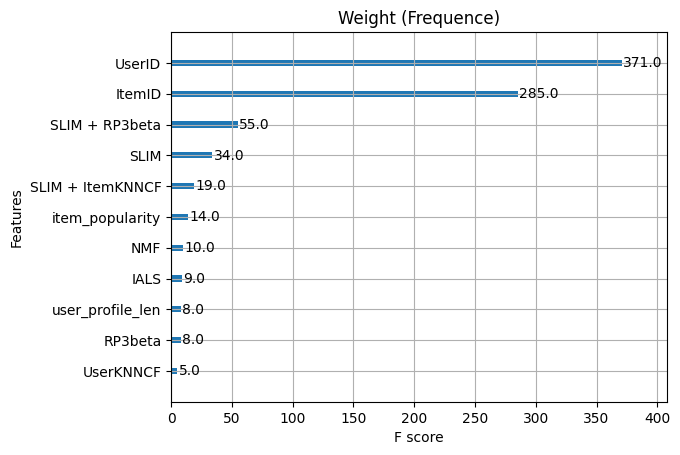

In [78]:
xgb.plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)')

In [98]:
predictions = XGB_model.predict(X_train)

In [112]:
predictions.min()

-1.4784268

In [101]:
X_train.shape

(379140, 11)

In [ ]:
for i in range(0,urm_validation.shape[0]):
    print(f'{urm_validation[i].nnz}')